In [220]:
# --------------------------------------------
# IMPORT LIBRAIRIES
# --------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib

import func_causalite as f
importlib.reload(f)

pd.set_option('display.max_rows', None)

# Génération des données

In [221]:
Nobs = 10000 # nombre d'observations
alpha_tau = 2 #effet du traitement
alpha_eZ = [2,2,1,-1] #effet des covariables sur le propensity score
NZ = np.size(alpha_eZ) # nombre de covariables
alpha_eY = [-3,-2,1,-1] #effet des covariables sur la variable d'intérêt
NY = np.size(alpha_eY) # nombre de covariables
alphaCross_eZ = np.zeros((NZ,NZ)) #effet croisé des covariables sur le propensity score
alphaCross_eY = np.zeros((NY,NY)) #effet croisé des covariables sur la variable d'intérêt
alphaCross_eZ[0,1] = 2 #effet croisé des covariables sur le propensity score
alphaCross_eY[0,1] = 0 #effet croisé des covariables sur la variable d'intérêt
alphaCross_eY[0,2] = -2 #effet croisé des covariables sur la variable d'intérêt
alphaCross_eY[0,3] = 2 #effet croisé des covariables sur la variable d'intérêt
df, tau_pf, tau_causal = f.genData(Nobs,alpha_tau,alpha_eZ,alpha_eY,alphaCross_eZ,alphaCross_eY)
print('tau_pf = E[Y,Z=1] - E[Y,Z=0] =', round(tau_pf,ndigits=3))   
print('tau_causal = E[Y(1)] - E[Y(0)] =', round(tau_causal ,ndigits=3))

tau_pf = E[Y,Z=1] - E[Y,Z=0] = -0.07
tau_causal = E[Y(1)] - E[Y(0)] = 0.291


# Outcome regression : moyenne par strate

In [222]:
# Regrouper par (X1, X2, Z) et calculer la moyenne de Y et l'effectif
grouped = df.groupby(['X1', 'X2', 'X3', 'X4', 'Z']).agg(
    mean_Y=('Y', 'mean'),
    count=('Y', 'count')
).reset_index()

# Réorganiser les résultats pour avoir les colonnes séparées pour Z=0 et Z=1
pivoted = grouped.pivot(index=['X1', 'X2', 'X3', 'X4'], columns='Z', values=['mean_Y', 'count'])

# Renommer les colonnes pour plus de clarté
pivoted.columns = ['E[Y|Z=0]', 'E[Y|Z=1]', 'N(Z=0)', 'N(Z=1)']
pivoted = pivoted.fillna(0)  # Remplir les valeurs NaN si une combinaison (X1, X2, Z) est absente

# Calcul de la différence E[Y | Z=1] - E[Y | Z=0]
pivoted['Diff'] = pivoted['E[Y|Z=1]'] - pivoted['E[Y|Z=0]']

# Calcul du poids total N(Z=0) + N(Z=1)
pivoted['Poids'] = pivoted['N(Z=0)'] + pivoted['N(Z=1)']

# Calcul de la moyenne pondérée
tau_est1 = (pivoted['Diff'] * pivoted['Poids']).sum() / pivoted['Poids'].sum()

# Affichage des résultats
print(pivoted)
print("\ntau_estimé =", round(tau_est1, 3))

             E[Y|Z=0]  E[Y|Z=1]  N(Z=0)  N(Z=1)      Diff   Poids
X1 X2 X3 X4                                                      
0  0  0  0   0.860294  1.000000   272.0     9.0  0.139706   281.0
         1   0.717033  1.000000   364.0    10.0  0.282967   374.0
      1  0   0.925806  1.000000   310.0    32.0  0.074194   342.0
         1   0.845149  1.000000   536.0    31.0  0.154851   567.0
   1  0  0   0.451178  0.814159   297.0   113.0  0.362981   410.0
         1   0.259887  0.611940   531.0    67.0  0.352053   598.0
      1  0   0.707407  0.956229   270.0   297.0  0.248822   567.0
         1   0.435860  0.851064   686.0   235.0  0.415204   921.0
1  0  0  0   0.199396  0.677778   331.0    90.0  0.478382   421.0
         1   0.411538  0.932203   520.0    59.0  0.520665   579.0
      1  0   0.089506  0.411985   324.0   267.0  0.322479   591.0
         1   0.227053  0.701031   621.0   194.0  0.473978   815.0
   1  0  0   0.000000  0.245487    23.0   554.0  0.245487   577.0
         1

# Simulations OR et IPW

tau_pf = E[Y,Z=1] - E[Y,Z=0] = -0.07
tau_causal = E[Y(1)] - E[Y(0)] = 0.291
tau_estimé (OR reg. log.) = 0.296
tau_estimé (OR arb. dec.) = 0.12
tau_estimé (IPW reg.log.) = 0.323
tau_estimé (IPW reg.log.) = 0.294


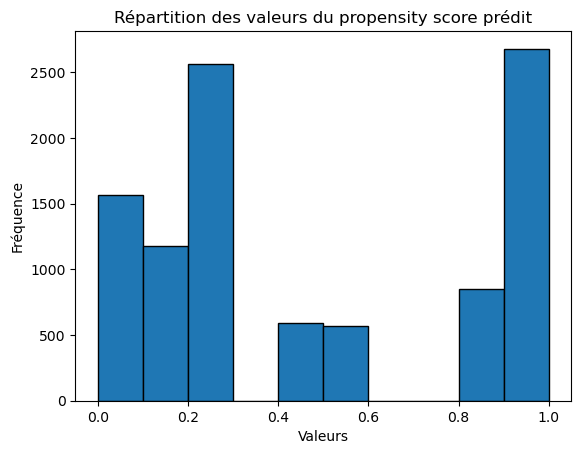

In [224]:
print('tau_pf = E[Y,Z=1] - E[Y,Z=0] =', round(tau_pf,ndigits=3))   
print('tau_causal = E[Y(1)] - E[Y(0)] =', round(tau_causal ,ndigits=3))
tau_est2 = f.regLogY(df)
tau_est3 = f.regArbY(df)
tau_est4, e_pred = f.regLogE(df)
tau_est5, e_pred = f.regArbE(df)
print("tau_estimé (OR reg. log.) =", round(tau_est2, 3))
print("tau_estimé (OR arb. dec.) =", round(tau_est3, 3))
print("tau_estimé (IPW reg.log.) =", round(tau_est4, 3))
print("tau_estimé (IPW reg.log.) =", round(tau_est5, 3))

# Tracer l'histogramme propensity score
plt.hist(e_pred, bins=10, edgecolor='black', range=(0, 1))  # 'bins' définit le nombre de bacs dans l'histogramme

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Répartition des valeurs du propensity score prédit')

# Afficher l'histogramme
plt.show()